In [24]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [25]:
print(iris_data.DESCR)


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [26]:
features = iris_data.data
labels = iris_data.target

In [27]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

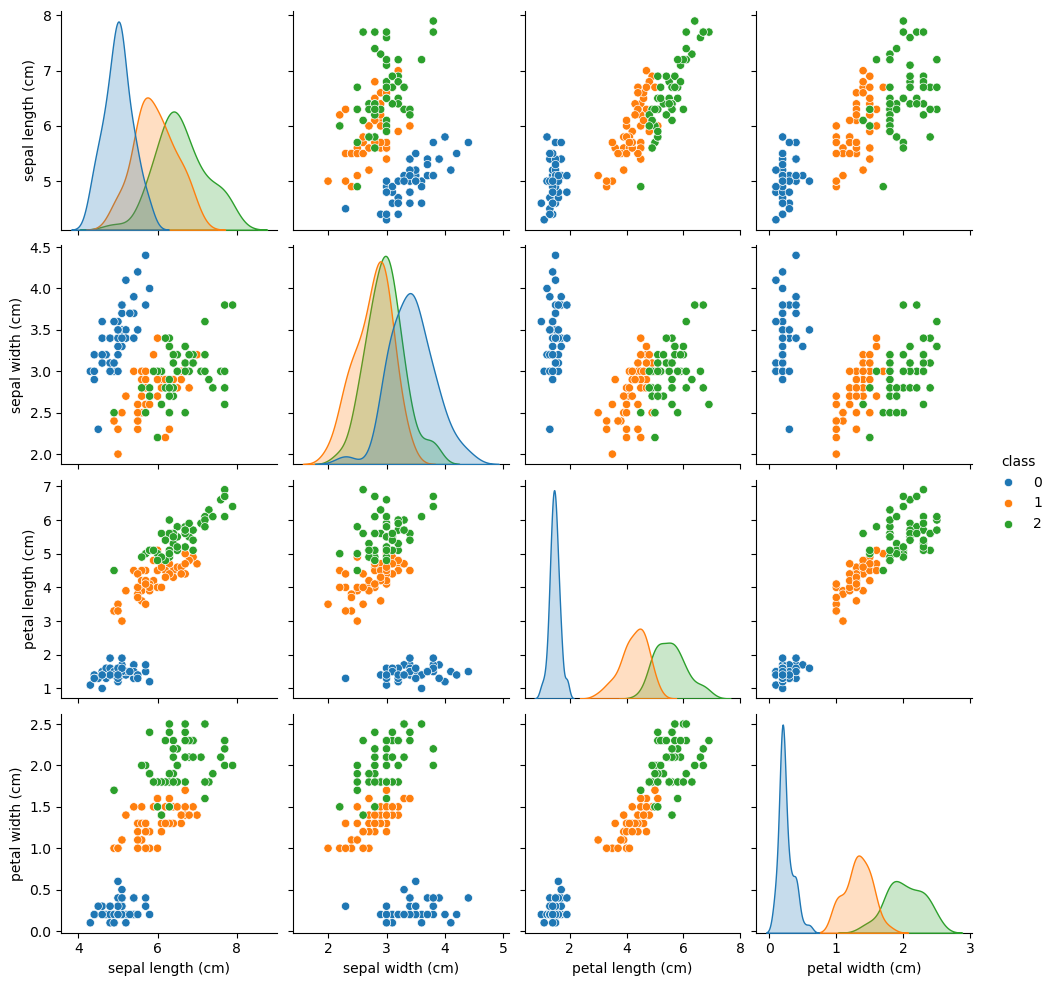

In [28]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

In [110]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [111]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [112]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


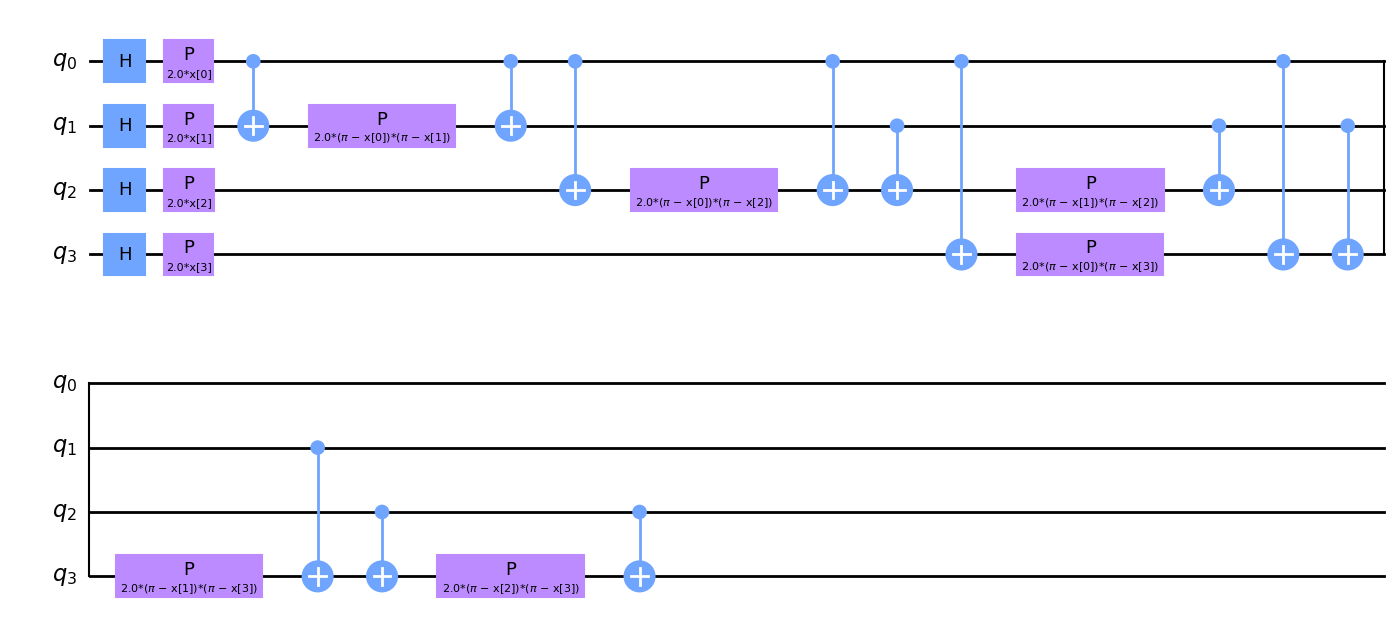

In [113]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

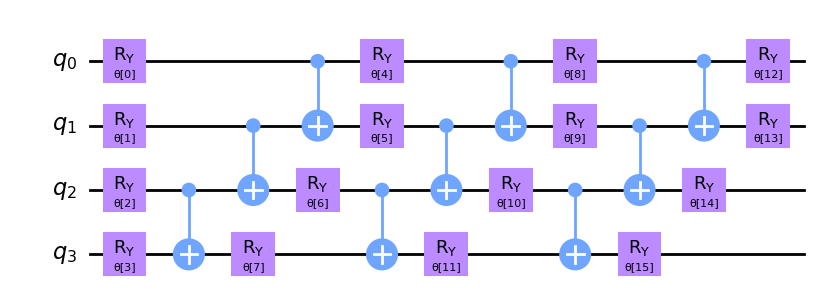

In [114]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [115]:
from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=200)

In [116]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

In [117]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [118]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [119]:
train_features0 = train_features
test_features0 = test_features


In [147]:
import numpy as np
train_features = train_features0
test_features = test_features0

# Min-max scaling function with training stats
def minmax_scale_to_pi_train_test(data, train_min, train_max):
    scaled_data = (data - train_min) / (train_max - train_min)  # Scale to [0, 1]
    scaled_data = scaled_data - 0.5
    scaled_data = scaled_data * np.pi * 2/6
    #scaled_data = scaled_data * np.pi * 1/2

    return scaled_data
    

# Compute min and max from training data
train_min = np.min(train_features, axis=0)
train_max = np.max(train_features, axis=0)
# Print to verify the range
print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )

# Scale training and test data
train_features = minmax_scale_to_pi_train_test(train_features, train_min, train_max)
test_features = minmax_scale_to_pi_train_test(test_features, train_min, train_max)
print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )



train range: 0.0 to 1.0  mean of  0.45401757689893274
test range: 0.0 to 0.9661016949152543  mean of  0.42739524482109226
train range: -0.5235987755982988 to 0.5235987755982988  mean of  -0.05237229137260893
test range: -0.5535187056324875 to 0.488100553523838  mean of  -0.08051951133370897


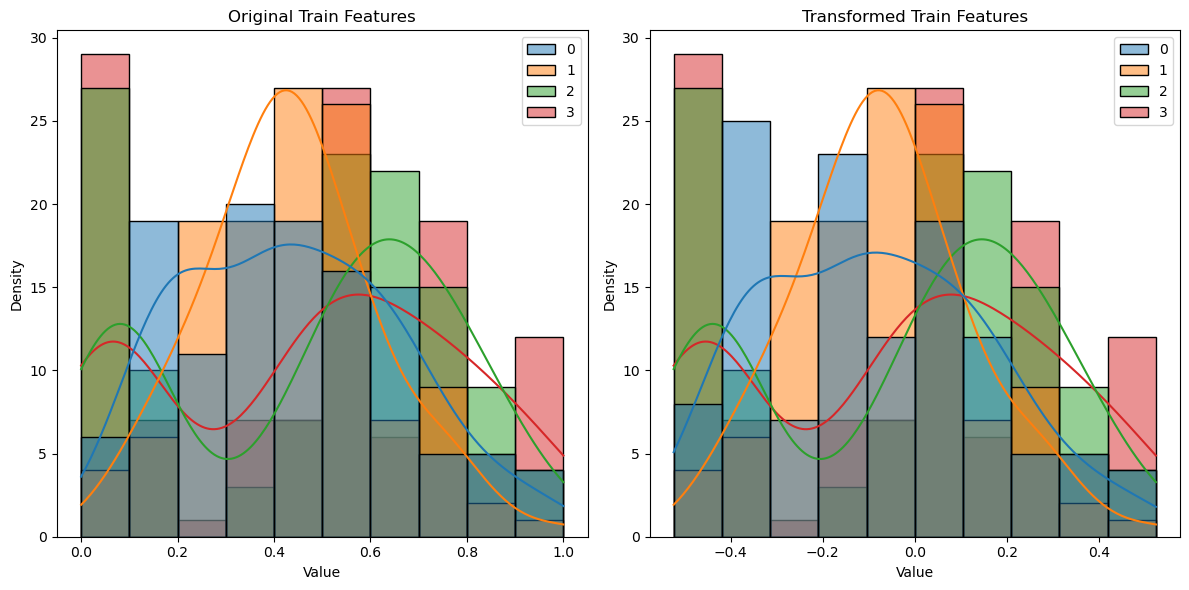

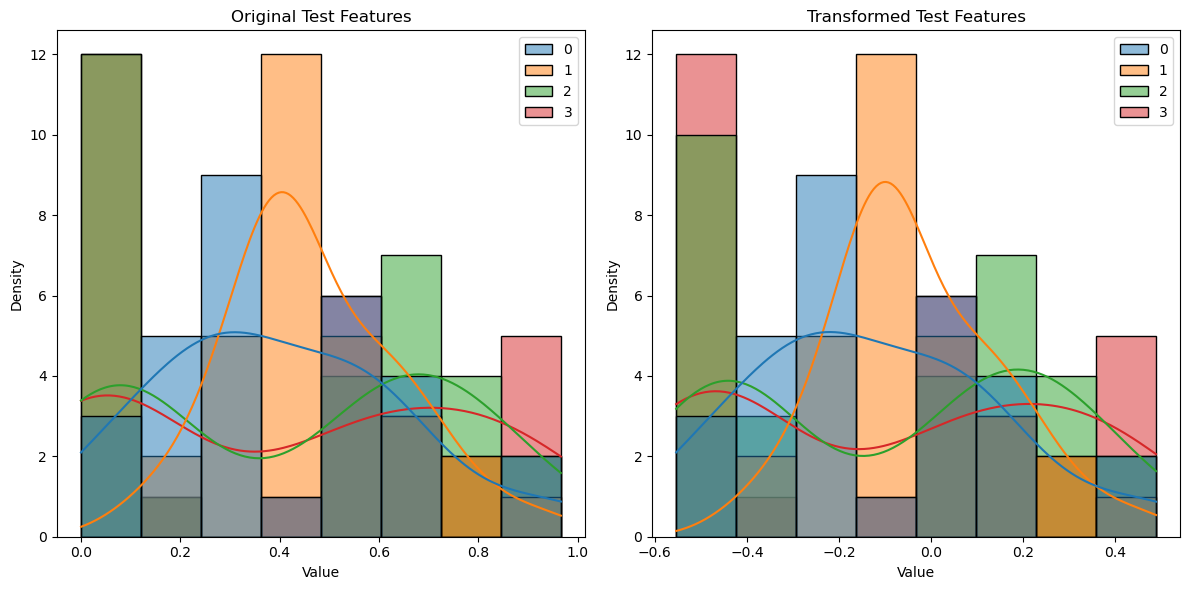

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of train_features
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(train_features0, kde=True, color='blue', label='Original Train Features')
plt.title('Original Train Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(train_features, kde=True, color='green', label='Transformed Train Features')
plt.title('Transformed Train Features')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Plot the distribution of test_features
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(test_features0, kde=True, color='blue', label='Original Test Features')
plt.title('Original Test Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(test_features, kde=True, color='green', label='Transformed Test Features')
plt.title('Transformed Test Features')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [149]:
idx = train_features > np.mean(train_features)
#train_features[idx] = train_features[idx] + np.pi / 3
train_features[idx] = train_features[idx] + np.pi / 4 # Pretty good

# since mean is negative, will do equal to negative
idx = train_features <= np.mean(train_features)
train_features[idx] = train_features[idx] - np.pi / 4

idx = test_features > np.mean(test_features)
test_features[idx] = test_features[idx] + np.pi / 4
# since mean is negative, will do equal to negative
idx = test_features <= np.mean(test_features)
test_features[idx] = test_features[idx] - np.pi / 4

print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )

train range: -1.308996938995747 to 1.308996938995747  mean of  0.00980506322968906
test range: -1.3389168690299358 to 1.2734987169212864  mean of  -0.09360948072366643


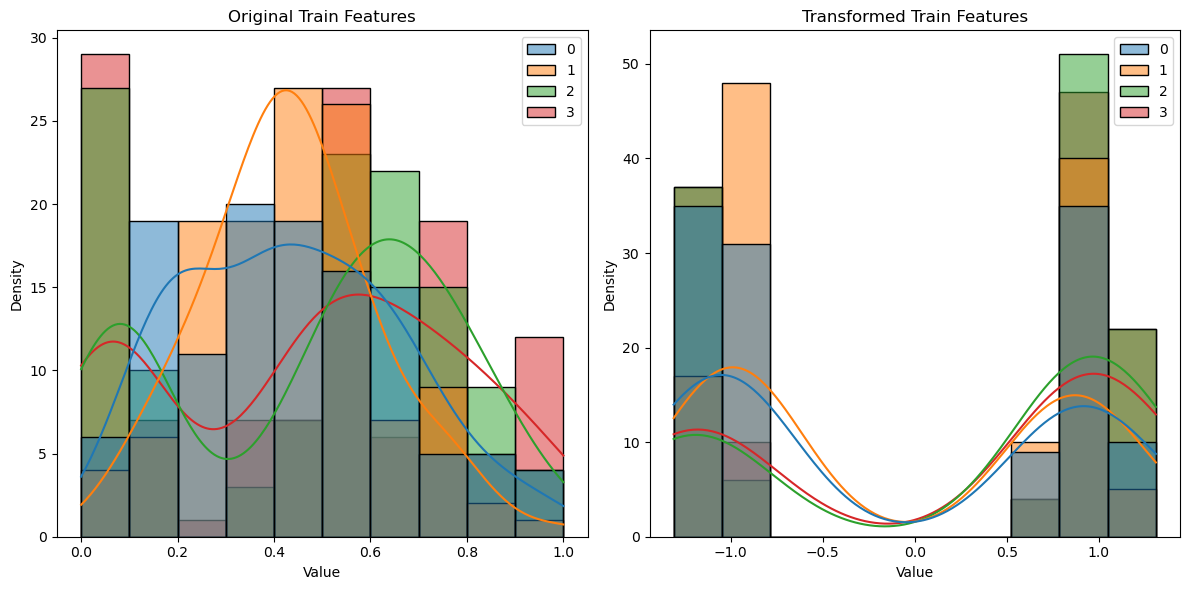

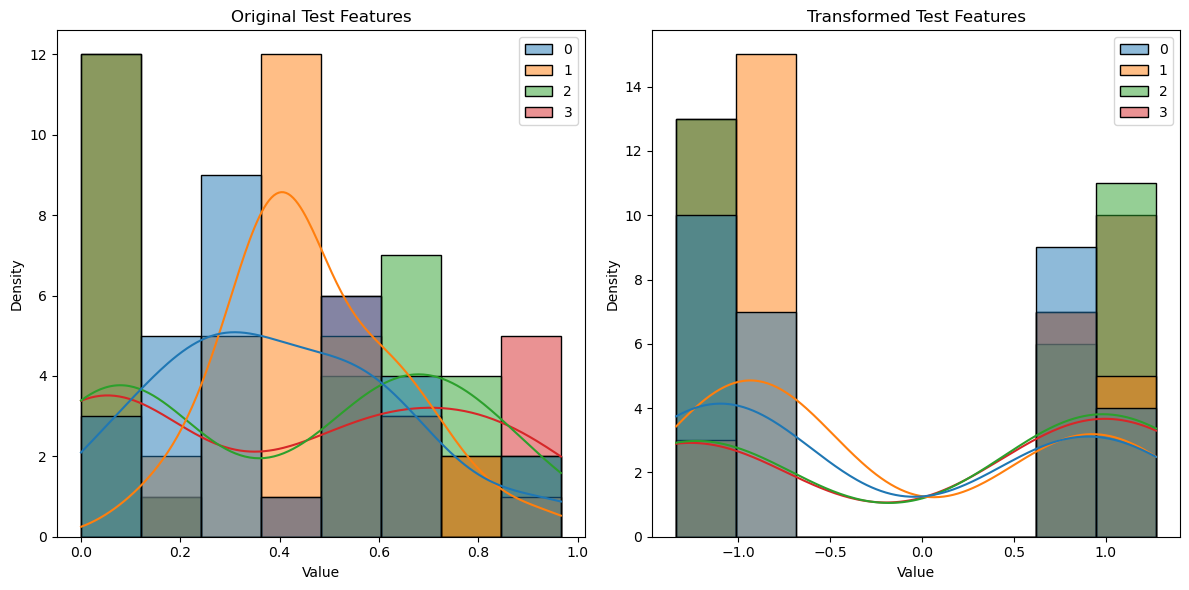

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of train_features
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(train_features0, kde=True, color='blue', label='Original Train Features')
plt.title('Original Train Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(train_features, kde=True, color='green', label='Transformed Train Features')
plt.title('Transformed Train Features')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Plot the distribution of test_features
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(test_features0, kde=True, color='blue', label='Original Test Features')
plt.title('Original Test Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(test_features, kde=True, color='green', label='Transformed Test Features')
plt.title('Transformed Test Features')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

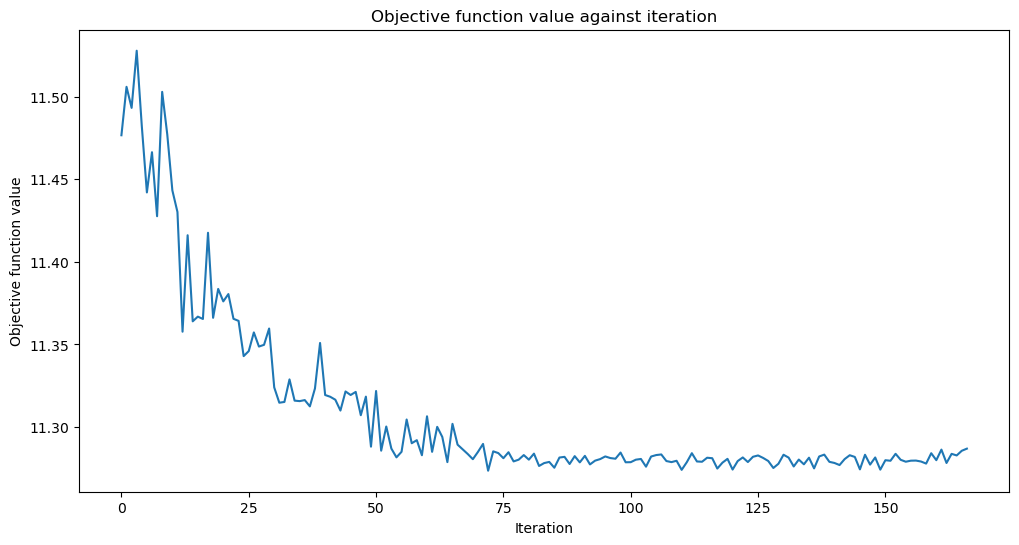

Training time: 111 seconds


In [151]:
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [152]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.53
Quantum VQC on the test dataset:     0.57


<Axes: >

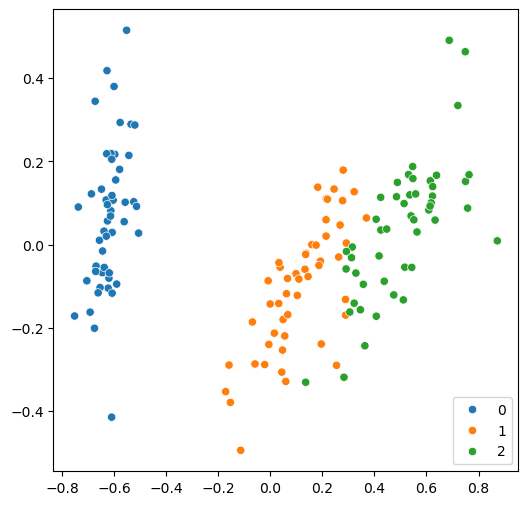

In [153]:
# Reducing the Number of Features
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [154]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


In [156]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

optimizer = COBYLA(maxiter=40)


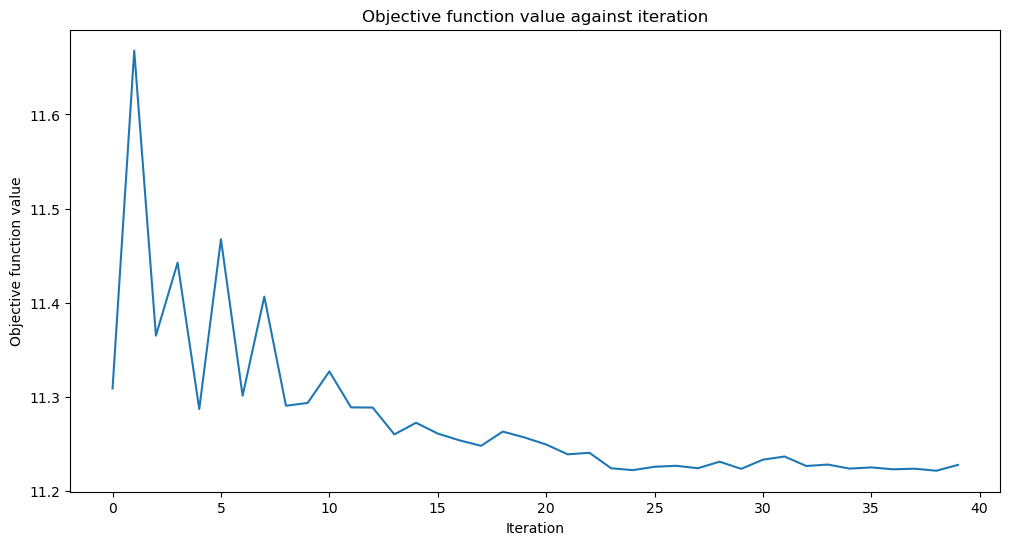

Training time: 20 seconds


In [157]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [158]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.53
Quantum VQC on the test dataset using RealAmplitudes:     0.47


In [161]:
import numpy as np
train_features = train_features0
test_features = test_features0

# Min-max scaling function with training stats
def minmax_scale_to_pi_train_test(data, train_min, train_max):
    scaled_data = (data - train_min) / (train_max - train_min)  # Scale to [0, 1]
    scaled_data = scaled_data - 0.5
    scaled_data = scaled_data * np.pi * 2/6
    #scaled_data = scaled_data * np.pi * 1/2

    return scaled_data
    

# Compute min and max from training data
train_min = np.min(train_features, axis=0)
train_max = np.max(train_features, axis=0)
# Print to verify the range
print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )

# Scale training and test data
train_features = minmax_scale_to_pi_train_test(train_features, train_min, train_max)
test_features = minmax_scale_to_pi_train_test(test_features, train_min, train_max)
print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )


idx = train_features > np.mean(train_features)
#train_features[idx] = train_features[idx] + np.pi / 3
train_features[idx] = train_features[idx] + np.pi / 4 # Pretty good

# since mean is negative, will do equal to negative
idx = train_features <= np.mean(train_features)
train_features[idx] = train_features[idx] - np.pi / 4

idx = test_features > np.mean(test_features)
test_features[idx] = test_features[idx] + np.pi / 4
# since mean is negative, will do equal to negative
idx = test_features <= np.mean(test_features)
test_features[idx] = test_features[idx] - np.pi / 4

print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )

train range: 0.0 to 1.0  mean of  0.45401757689893274
test range: 0.0 to 0.9661016949152543  mean of  0.42739524482109226
train range: -0.5235987755982988 to 0.5235987755982988  mean of  -0.05237229137260893
test range: -0.5535187056324875 to 0.488100553523838  mean of  -0.08051951133370897
train range: -1.308996938995747 to 1.308996938995747  mean of  0.00980506322968906
test range: -1.3389168690299358 to 1.2734987169212864  mean of  -0.09360948072366643


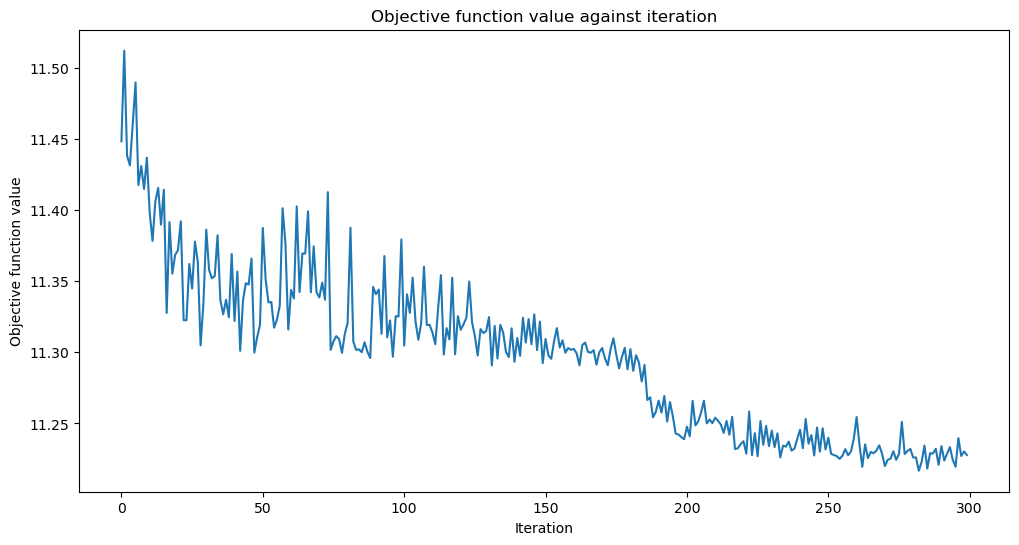

Training time: 416 seconds


In [172]:
from qiskit.circuit.library import EfficientSU2

num_features = test_features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=num_features)

ansatz = EfficientSU2(num_qubits=num_features, reps=num_features)
optimizer = COBYLA(maxiter=300)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [173]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.63
Quantum VQC on the test dataset using EfficientSU2:     0.37


In [29]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.99 |       0.97
VQC, 4 features, RealAmplitudes |       0.62 |       0.57
----------------------------------------------------------
SVC, 2 features                 |       0.97 |       0.90
VQC, 2 features, RealAmplitudes |       0.45 |       0.20
VQC, 2 features, EfficientSU2   |       0.68 |       0.63
